# DIP test-Multimodal detection

Desarrollar y probar herramientas para la deteccion de distribuciones embebidas dentro de una variable (1D). Si es posible, se apliara el analisis a 2D. Para ello sera usado un KDE optimizado y el DIP test que evalua si una variable es unimodal o no.


### References

- [Modality tests and kernel density estimations (toward data science)](https://towardsdatascience.com/modality-tests-and-kernel-density-estimations-3f349bb9e595)


In [58]:
!pip install unidip
!pip install simdkalman

In [60]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import simdkalman

In [61]:
def getExtremePoints(data, typeOfInflexion = None, maxPoints = None):
    """
    This method returns the indeces where there is a change in the trend of the input series.
    typeOfInflexion = None returns all inflexion points, max only maximum values and min
    only min,
    """
    a = np.diff(data)
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    idx = np.where(signchange ==1)[0]

    if typeOfInflexion == 'max' and data[idx[0]] < data[idx[1]]:
        idx = idx[1:][::2]
        
    elif typeOfInflexion == 'min' and data[idx[0]] > data[idx[1]]:
        idx = idx[1:][::2]
    elif typeOfInflexion is not None:
        idx = idx[::2]
    
    # sort ids by min value
    if 0 in idx:
        idx = np.delete(idx, 0)
    if (len(data)-1) in idx:
        idx = np.delete(idx, len(data)-1)
    idx = idx[np.argsort(data[idx])]
    # If we have maxpoints we want to make sure the timeseries has a cutpoint
    # in each segment, not all on a small interval
    if maxPoints is not None:
        idx= idx[:maxPoints]
        if len(idx) < maxPoints:
            return (np.arange(maxPoints) + 1) * (len(data)//(maxPoints + 1))
    
    return idx

## real dataset

<AxesSubplot:ylabel='Density'>

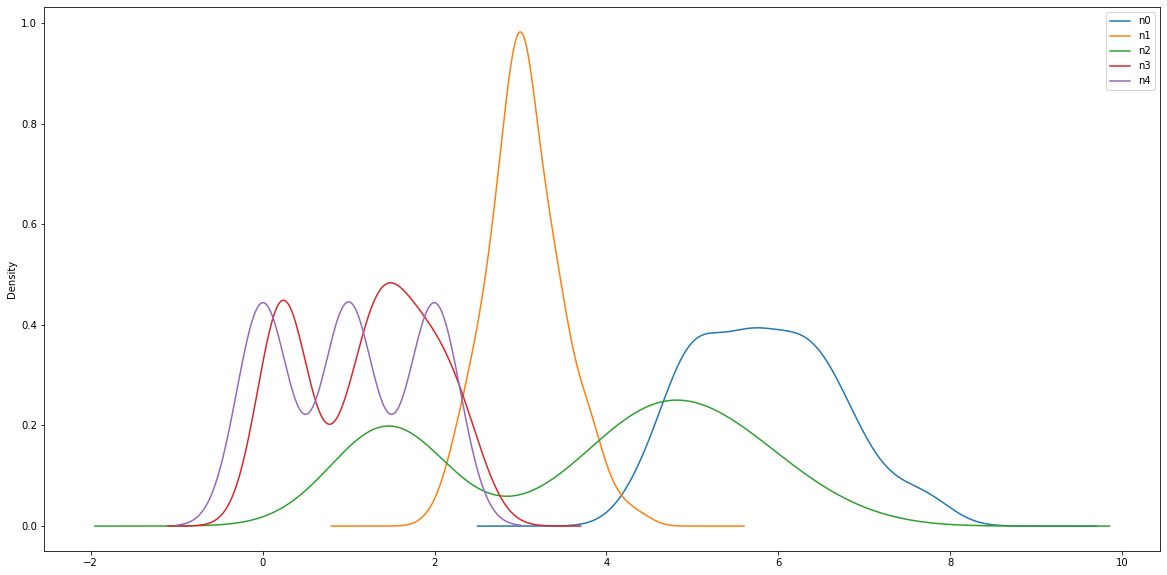

In [40]:
## DATASET

# load dataset
dataset = load_iris()
dataset.keys()
# dataset to df
data = pd.DataFrame(dataset.data, columns = dataset.feature_names)
data['class'] = dataset.target
dclass = dict()
for i, ic in enumerate(dataset.target_names):
    dclass[i] = ic

## FORMAT 

# check what columns are NUMERICAL or CATEGORICAL
cols_num = data.select_dtypes(include=['float64', 'int64']).columns.values  # numerical columns
cols_cat = data.select_dtypes(include=['object']).columns.values            # categorical columns
# columns name converters: numerical
dcols_num_name_to_alias = dict()
dcols_num_alias_to_name = dict()
for i, ic in enumerate(cols_num):
    dcols_num_name_to_alias[ic] = 'n{}'.format(i)
    dcols_num_alias_to_name['n{}'.format(i)] = ic
# columns name converters: categorical
dcols_cat_name_to_alias = dict()
dcols_cat_alias_to_name = dict()
for i, ic in enumerate(cols_cat):
    dcols_cat_name_to_alias[ic] = 'c{}'.format(i)
    dcols_cat_alias_to_name['c{}'.format(i)] = ic
# rename columns
data.rename(columns = dcols_num_name_to_alias, inplace = True)
data.rename(columns = dcols_cat_name_to_alias, inplace = True)
# list of alias
cols_num_alias = list(dcols_num_name_to_alias.values())
cols_cat_alias = list(dcols_cat_name_to_alias.values())

## PLOT

data.plot.kde(figsize = (20,10))

# Uniform distribution data

<AxesSubplot:ylabel='Frequency'>

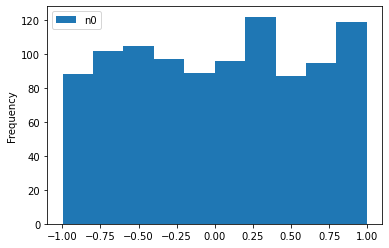

In [41]:
# random data
s = np.random.uniform(-1,1,1000)
# to df
datarandom = pd.DataFrame({'n0':s})
# plot
datarandom.plot(kind = 'hist', bins = 10)

# Gaussian distribution data (Unimodal, Multimodal)

<AxesSubplot:ylabel='Frequency'>

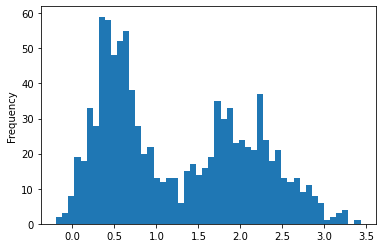

In [42]:
## Unimodal
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
datagauss = pd.DataFrame({'uni': s})
## Multimodal
mu1, sigma1 = 2, 0.5 # mean and standard deviation
s1 = np.random.normal(mu1, sigma1, 500)
s = np.concatenate((s1, 0.5*s1 - .5))
datagauss['multi'] = s
## plot
datagauss.multi.plot(kind = 'hist', bins = 50)

# ANALYSIS 1D

### KDE

In [90]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
v = data.n3.values
x = np.linspace(v.min(),v.max(), v.shape[0])
stats_models_cv = KDEMultivariate(v, 'c', bw = 'cv_ml').pdf(x)
idx = getExtremePoints(stats_models_cv, typeOfInflexion='max')

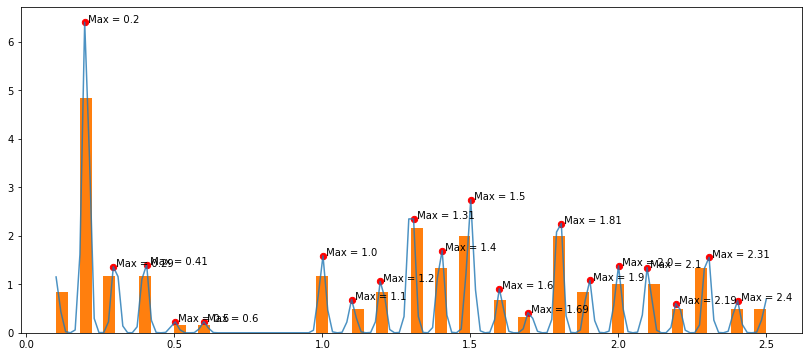

In [91]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize= (14, 6))
ax.plot(x, stats_models_cv, alpha = 0.8, label = f'Statsmodels CV maximum likelihood')
ax.hist(v, density = True, bins = 60)

for i in idx:
    ax.scatter(x[i], stats_models_cv[i], s= 40, c = 'red')

for i in idx:
    ax.annotate(f' Max = {round(x[i], 2)}', (x[i], stats_models_cv[i]))
plt.show()